In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import DataLoader
import kornia.augmentation as K
import timm
from torchinfo import summary
from rich.pretty import pprint
import torch.optim as optim
import torch
import time

# Introduction
In this project we explore the use of deep learning to identify the state of seeds.

The paper describing the data gathering process can be found [here](https://www.nature.com/articles/s41597-023-02660-8)

We focus entirely on wheat data for which can be found [here](https://figshare.com/articles/figure/wheat_zip/22992317/2). 

The data comes already split into a training (90%) and test set (10%), corresponding to 180k and 20k images respectively. We will hold out the test set in training and split the training set into training and validation (70% to 30%). Cross-validation was not feasible with this dataset due to computational constraints.

In [2]:
def get_class_label(path: str) -> str:
    return os.path.basename(path).split("_")[1]


In [3]:
# Assemble lists of files for every class as well as class labels
train_path = "../GrainSetData/wheat/train"
test_path = "../GrainSetData/wheat/test"
paths = sorted(glob.glob(f"{train_path}/*"))
classes = dict([z.split("_")[::-1] for z in [os.path.basename(x) for x in paths]])
classes = {k: int(v) for k, v in classes.items()}


In [4]:
# Save a list of training images. We do not use them during training
# except to ensure that they are not included in train/val datasets
test_images = []
for k in os.listdir(test_path):
    test_images.extend(
        [os.path.basename(x).split(".")[0] for x in glob.glob(f"{test_path}/{k}/*.png")]
    )

The data comes with a metadata file that describes _all_ data.


In [5]:
df_meta = pd.read_xml("../GrainSetData/wheat/wheat.xml")

In [6]:
# Sort the data in the same order as the classes
df_meta["prio"] = pd.Categorical(df_meta["DU_grain"], categories=classes, ordered=True)
df_meta = df_meta.sort_values("prio")

In [7]:
df_meta.head()

,ID,species,sub-species,location,time,size,DU_grain,weight,prio
99999,Grainset_wheat_2021-06-08-17-16-55_12_p600s,wheat,hexaploid common,CN,2017-02-25,15,NOR,40,NOR
105995,Grainset_wheat_2022-01-07-14-55-20_17_p600s,wheat,hexaploid common,USA,2017-08-02,19,NOR,54,NOR
105996,Grainset_wheat_2022-08-26-15-05-05_12_p600s,wheat,hexaploid common,CN,2016-02-16,18,NOR,47,NOR
105997,Grainset_wheat_2021-08-14-15-57-17_24_p600s,wheat,hexaploid common,USA,2016-02-15,15,NOR,40,NOR
105998,Grainset_wheat_2021-09-20-09-46-38_12_p600s,wheat,hexaploid common,CN,2019-07-02,16,NOR,44,NOR


In [8]:
df_meta[["species", "sub-species", "location", "DU_grain"]].apply(pd.unique)

species                                   [wheat]
sub-species                    [hexaploid common]
location                       [CN, USA, AU, CAN]
DU_grain       [NOR, F&S, SD, MY, AP, BN, BP, IM]
dtype: object

The definitions of various columns:

* ID: path to the file
* species: the species of the grain, in our case always "wheat"
* sub-species: the subspecies of the grain, in our case always "hexaploid common"
* location: where grain is from (AU - Australia,  CAN - Canada, CN - China, USA - USA )
* size: the area of the grain, in ${\rm mm}^{2}$ 
* DU_grain:
    * NOR - normal
    * F&S - fusarium and shriveled: kernels attacked by fungi from the Fusarium genus. As a result these grains may contain _toxic_ substances and have a strong negative effect on food safety
    * SD - sprouted: grains in the process of germinating
    * MY - moldy: grains contaminated by mold or fungi (other than Fusarium)
    * BN - broken: kernels that have been physically fractured
    * AP - attacked by pests: kernels that have been infested by pests (insects of various kinds)
    * BP - black point: kernels that have been affected by fungal infections or insect damage
    * IM - impurity: not actually wheat but some other material/debris which was not filtered out during processing
* weight: the weight in grams

The goal of our analysis is to use the images identified by the ID and train the model to predict the DU_grain class.

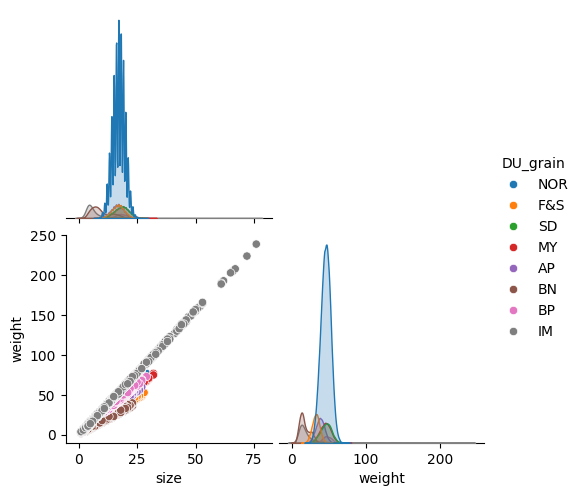

In [9]:
pp = sns.pairplot(df_meta[["size", "weight", "DU_grain"]], hue="DU_grain", corner=True)

<Axes: xlabel='DU_grain', ylabel='Count'>

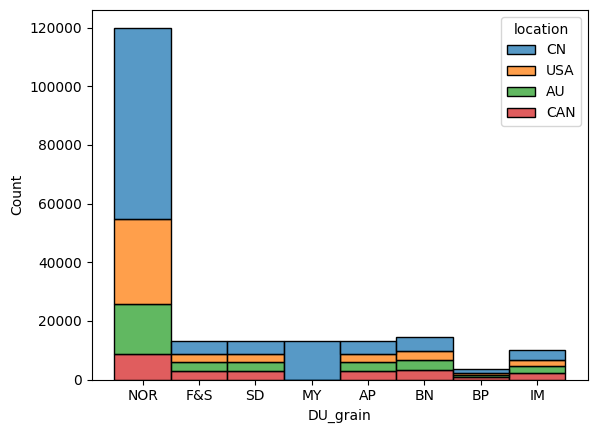

In [10]:
# Plot the distribution of classes
sns.histplot(df_meta, x="DU_grain", hue="location", multiple="stack")

It's clear that we have unbalanced classes: in particular there are far more samples in the normal category than there are in the others. This is entirely expected as most grains are in nominal condition. Thus we will need to be careful when assessing the accuracy of our classifier, and use the F1 score and not just the raw accuracy.

In [354]:
classes

{'NOR': 0, 'F&S': 1, 'SD': 2, 'MY': 3, 'AP': 4, 'BN': 5, 'BP': 6, 'IM': 7}

In [355]:
class_meanings = [
    "Normal",
    "Fusarium",
    "Sprouted",
    "Moldy",
    "Attacked by pests",
    "Broken",
    "Black point",
    "Impurities",
]
class_explanations = dict(zip(classes.keys(), class_meanings))

Let's take a look at the actual image data, by loading 1 image from every category

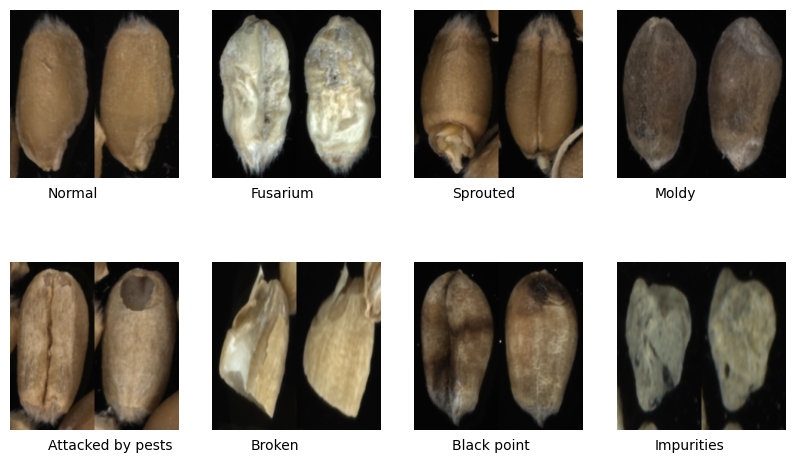

In [356]:
fig, axs = plt.subplots(2, 4, figsize=(10, 6))
axs = axs.flat
size = (224, 224)
for i, (cls, num) in enumerate(classes.items()):
    pth = os.path.join(train_path, f"{num}_{cls}")
    img_pth = sorted(glob.glob(f"{pth}/*"))[2]
    image = Image.open(img_pth).convert("RGB")
    image = image.resize(size, Image.Resampling.LANCZOS)
    axs[i].imshow(image)
    axs[i].text(50, 250, class_explanations[cls])
    axs[i].set_axis_off()

A few things to note:
* each image consists of both an up and a down view
* the original images are _not_ the same size and must be resized. **NOTE: we will always resize the images to 224x224 size**
* some images may have other grains in the background
* there are indeed visual indicators of the different grain states. That is exactly what our classifier should learn.

# Preparing the data

The first thing we do is split the data in the training directory into training and validation. This will help us:

* tune any hyperparameters
* assess which of the models we train should be selected to be trained on the entire dataset

We choose to split the training set into 70% training and 30% validation. This results in ~120k images for training and ~60k images for validation.

In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

random_state = 42
val_frac = 0.3

In [14]:
# The metadata file contains all data, including testing. We exclude testing files here
df_meta_train = df_meta[~df_meta["ID"].isin(test_images)].reset_index(drop=True)
df_meta_test = df_meta[df_meta["ID"].isin(test_images)].reset_index(drop=True)

In [ ]:
# Save lists of training and validation data
df_meta_train["label"] = df_meta_train["DU_grain"].map(classes)

df_meta_train["img_path"] = (
    f"{train_path}/"
    + df_meta_train["label"].astype(str)
    + "_"
    + df_meta_train["DU_grain"]
    + "/"
    + df_meta_train["ID"]
    + ".png"
)


df_train, df_val = train_test_split(
    df_meta_train[["img_path", "label"]],
    test_size=val_frac,
    random_state=random_state,
    stratify=df_meta_train["label"],
)
df_train.to_json("training_list.json", indent=4)
df_val.to_json("validation_list.json", indent=4)



In [ ]:
# Save list of the test data
df_meta_test["label"] = df_meta_test["DU_grain"].map(classes)
df_meta_test["img_path"] = (
    f"{test_path}/"
    + df_meta_test["label"].astype(str)
    + "_"
    + df_meta_test["DU_grain"]
    + "/"
    + df_meta_test["ID"]
    + ".png"
)
df_meta_test[['img_path','label']].to_json("test_list.json", indent=4)

Let's check the distribution of classes is indeed the same between training and validation data

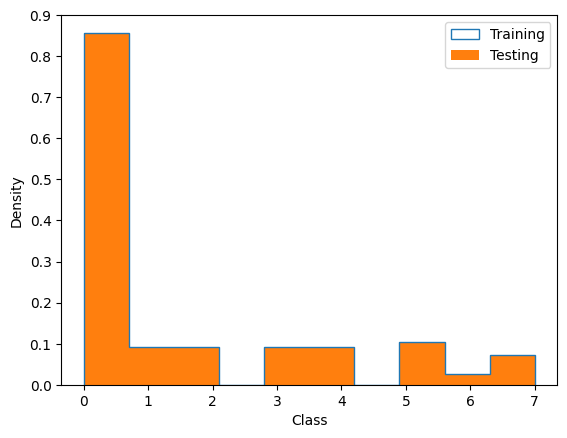

In [17]:
plt.figure()
plt.hist(df_train["label"], density=True, histtype="step", label="Training")
plt.hist(df_val["label"], density=True, label="Testing")
plt.xlabel("Class")
plt.ylabel("Density")
plt.legend(loc=1)

They are indeed the same.

# Training models
To start we will train a very simple, hand-created CNN classifier with very few parameters. While it's unlikely to reach high accuracy it provides a quick baseline.
Model training will be done in several steps:
- defining all our model and training settings
- building the pytorch CNN model
- creating a DataLoader to load the training and validation data
- defining loss and optimizer
- running the training loop

## Creating model settings
We must adjust training settings like number of epochs, learning rate, etc. For all our training we usually use the same settings so we have created them as defaults. See [training_config.py](./training_config.py)

In [162]:
from training_config import TrainingConfig

raw_conf = {"model_name": "BaselineCNNClassifier", "num_epochs": 3, "pretrained": False}
training_config = TrainingConfig(**raw_conf)

In [163]:
pprint(training_config)

TrainingConfig(
│   model_name='BaselineCNNClassifier',
│   pretrained=False,
│   num_epochs=3,
│   batch_size=128,
│   optimization=OptimizationConfig(weight_decay=0.0001, learning_rate=0.0001),
│   n_classes=8,
│   n_workers=4
)

## Constructing the model

In [164]:
from typing import Any
import torch.nn as nn
import torch.nn.functional as F


class BaselineCNNClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # input is (3,224,224)
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1
        )
        # (32,224,224)
        self.pool1 = nn.MaxPool2d((2, 2), 2)
        # (32,112,112)
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1
        )
        # (64,112,112)
        self.pool2 = nn.MaxPool2d((2, 2), 2)
        # (64,56,56)
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1
        )
        # (64,56,56)
        self.pool3 = nn.MaxPool2d((2, 2), 2)
        # (64,28,28)
        self.fc1 = nn.Linear(64 * 28 * 28, len(classes))

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [165]:
baseline_model = BaselineCNNClassifier()

In [166]:
summary(baseline_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
BaselineCNNClassifier                    [1, 8]                    --
├─Conv2d: 1-1                            [1, 32, 224, 224]         896
├─MaxPool2d: 1-2                         [1, 32, 112, 112]         --
├─Conv2d: 1-3                            [1, 64, 112, 112]         18,496
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Conv2d: 1-5                            [1, 64, 56, 56]           36,928
├─MaxPool2d: 1-6                         [1, 64, 28, 28]           --
├─Linear: 1-7                            [1, 8]                    401,416
Total params: 457,736
Trainable params: 457,736
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 393.18
Input size (MB): 0.60
Forward/backward pass size (MB): 20.87
Params size (MB): 1.83
Estimated Total Size (MB): 23.31

## Loading the data
Here we load the data as well as define several image augmentations, namely:
- resizing the image to 224x224
- for training:
    - random affine transformation with rotation, shear and scaling
    - random horizontal flip
- converting to tensor
- normalizing using the settings from ImageNet

In [167]:
from data_loader import prepare_dataset

In [168]:
train_dataset = prepare_dataset(
    "train_list.json", model_name=training_config.model_name
)
val_dataset = prepare_dataset(
    "validation_list.json", model_name=training_config.model_name
)

train_loader = DataLoader(
    train_dataset,
    batch_size=training_config.batch_size,
    shuffle=True,
    num_workers=training_config.n_workers,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=training_config.batch_size,
    shuffle=False,
    num_workers=training_config.n_workers,
    pin_memory=True,
    persistent_workers=True,
)

## Preparing the optimizer

In [169]:
optimizer = optim.Adam(
    baseline_model.parameters(),
    lr=training_config.optimization.learning_rate,
    weight_decay=training_config.optimization.weight_decay,
)
criterion = nn.CrossEntropyLoss()  # Does not need a softmax in the last layer!


## Training loop
Now we train the model. During training we also:
- evaluate the loss and accuracy on training and validation set
- write the training stats to file
- checkpoint the model so training can be resumed

**Note that even this simple model might take a while to train on a T4. The training for the project was done on AMD RX6090XT 16GB consumer graphics card. The training run took 25 minutes.**

In [170]:
from utils import write_model_checkpoint, write_model_training_stats

# Scaler is needed to scale the gradient to avoid underflow, since
# we are training using fp16
scaler = torch.amp.GradScaler("cuda")
# Choose the GPU or the CPU (note: CPU training is **very** slow)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Compile the model for extra speed
model = torch.compile(baseline_model)
# Put the model on the device. The 'memory_format' option is an
# opitmization for AMD GPUs
model.to(device, memory_format=torch.channels_last)


start_epoch = 0
print_freq = 100  # How frequently to print information

print("Beginning the training loop")
for epoch in range(start_epoch, training_config.num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    iteration = 0
    start_time = time.time()
    for inputs, labels in train_loader:
        # Move data to the specified device (GPU or CPU)

        inputs, labels = (
            inputs.to(device, memory_format=torch.channels_last, non_blocking=True),
            labels.to(device, non_blocking=True),
        )

        # Zero the parameter gradients to prevent accumulation
        optimizer.zero_grad()
        # Forward pass
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)
        # Backward pass and optimize
        if loss is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        if iteration % print_freq == 0:
            print(
                f"Epoch {epoch}: Iteration {iteration}/{len(train_loader)} - Loss: {loss.item():.4f} - Time {time.time() - start_time}"
            )
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Accumulate training loss
        running_loss += loss.item()
        iteration += 1

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move data to the specified device (GPU or CPU)
            inputs, labels = (
                inputs.to(device, memory_format=torch.channels_last, non_blocking=True),
                labels.to(device, non_blocking=True),
            )
            # Forward pass
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(inputs)
                # Calculate the loss
                loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    print(f"Epoch {epoch + 1}/{training_config.num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    end_time = time.time()
    print(f"Time for epoch = {end_time - start_time}")
    stats = [epoch, train_loss, train_acc, val_loss, val_acc, end_time - start_time]

    if epoch % 2 == 0:
        write_model_checkpoint(model, optimizer, stats, training_config.model_name)
    write_model_training_stats(stats, training_config.model_name)

print("Training completed!")

Beginning the training loop


Epoch 0: Iteration 0/985 - Loss: 2.0834 - Time 1.712580919265747
Epoch 0: Iteration 100/985 - Loss: 1.0409 - Time 24.444323539733887
Epoch 0: Iteration 200/985 - Loss: 0.8405 - Time 47.17245173454285
Epoch 0: Iteration 300/985 - Loss: 0.8027 - Time 69.90796661376953
Epoch 0: Iteration 400/985 - Loss: 0.8155 - Time 92.64443826675415
Epoch 0: Iteration 500/985 - Loss: 0.8959 - Time 115.37365984916687
Epoch 0: Iteration 600/985 - Loss: 0.6578 - Time 138.10476088523865
Epoch 0: Iteration 700/985 - Loss: 0.6821 - Time 160.84257435798645
Epoch 0: Iteration 800/985 - Loss: 0.6436 - Time 183.576247215271
Epoch 0: Iteration 900/985 - Loss: 0.5736 - Time 206.3173189163208
Epoch 1/3
  Train Loss: 0.7640, Train Acc: 0.7627
  Val Loss: 0.5161, Val Acc: 0.8486
Time for epoch = 289.50588607788086
Epoch 1: Iteration 0/985 - Loss: 0.5426 - Time 0.9257237911224365
Epoch 1: Iteration 100/985 - Loss: 0.4305 - Time 23.67496132850647
Epoch 1: Iteration 200/985 - Loss: 0.4604 - Time 46.42727756500244
Epoch 1

## Validating results
We validate the results by computing several different metrics on the validation set:
- accuracy
- precision
- recall
- F1 score
- confusion matrix

In [171]:
from evaluate_model import evaluate_model

model.eval()
df_trained, val_loss_trained, val_acc_trained = evaluate_model(
    model,
    val_dataset,
    training_config,
    output_file=f"accuracy_{training_config.model_name}_trained.csv",
)

[01/18/26 22:17:37] INFO     Creating data loaders                                             ]8;id=160142;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=887353;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/18/26 22:17:37] INFO     Creating data loaders                                             ]8;id=148806;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=219399;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/18/26 22:17:37] INFO     Creating data loaders                                             ]8;id=972274;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=533250;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/18/26 22:17:37] INFO     Creating data loaders                                             ]8;id=990919;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=256386;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/18/26 22:17:37] INFO     Creating data loaders                                             ]8;id=271375;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=933770;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=863431;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=806490;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=14787;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=600240;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=757037;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=450305;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=686872;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=831038;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=18741;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=643072;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

[01/18/26 22:18:39] INFO     Done                                                              ]8;id=174152;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=666898;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/18/26 22:18:39] INFO     Done                                                              ]8;id=971043;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=507231;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/18/26 22:18:39] INFO     Done                                                              ]8;id=300258;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=178879;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/18/26 22:18:39] INFO     Done                                                              ]8;id=391980;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=114737;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/18/26 22:18:39] INFO     Done                                                              ]8;id=602095;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=577200;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

                    INFO     Writing labels and predictions to                                 ]8;id=898266;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=791164;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#86\86]8;;\
                             accuracy_BaselineCNNClassifier_trained.csv                                            

                    INFO     Writing labels and predictions to                                 ]8;id=872486;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=817377;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#86\86]8;;\
                             accuracy_BaselineCNNClassifier_trained.csv                                            

                    INFO     Writing labels and predictions to                                 ]8;id=112564;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=622634;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#86\86]8;;\
                             accuracy_BaselineCNNClassifier_trained.csv                                            

                    INFO     Writing labels and predictions to                                 ]8;id=572493;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=941470;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#86\86]8;;\
                             accuracy_BaselineCNNClassifier_trained.csv                                            

                    INFO     Writing labels and predictions to                                 ]8;id=805297;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=87338;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#86\86]8;;\
                             accuracy_BaselineCNNClassifier_trained.csv                                            

In [172]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
)

conf_matrix = confusion_matrix(df_trained["labels"], df_trained["preds"])
# Normalize as percent of the right class
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)

Text(0.5, 47.7222222222222, 'Predicted Label')

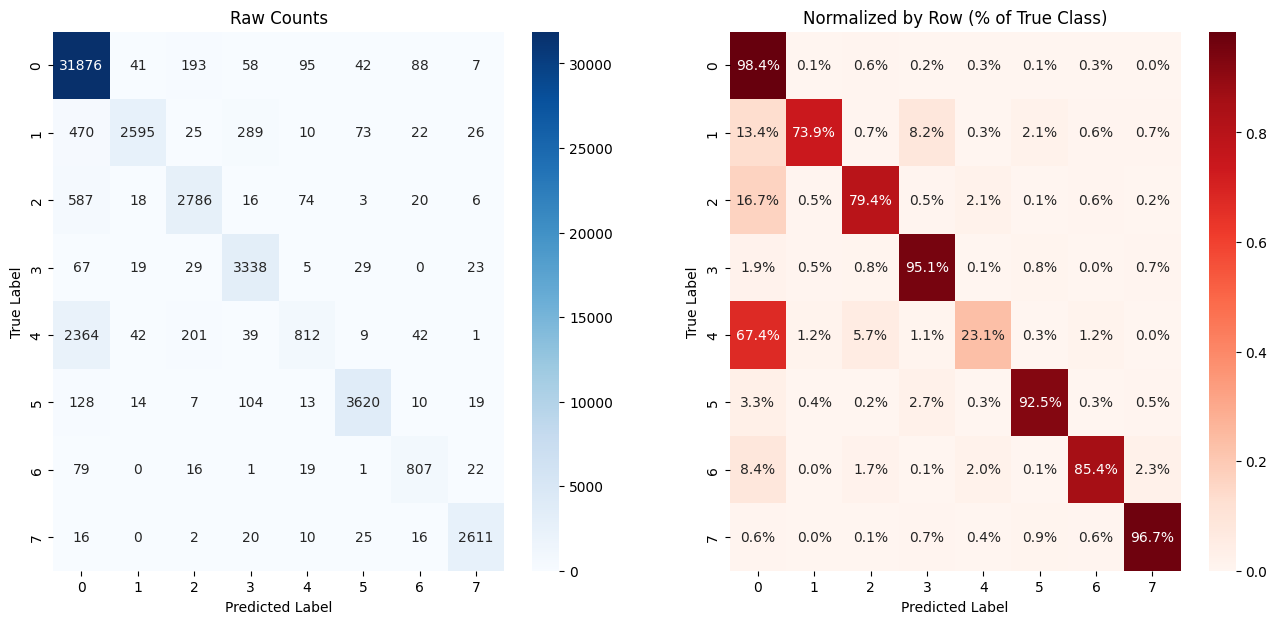

In [173]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
# Raw counts
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Raw Counts")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".1%", cmap="Reds", ax=axes[1])
axes[1].set_title("Normalized by Row (% of True Class)")
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")


From the confusion matrix plot above it's clear that while for most classes the model already does a fairly good job, that is not the case for images in class 4 which are mostly misclassified as class 0. 

In [174]:
precision = precision_score(df_trained["labels"], df_trained["preds"], average="macro")
recall = recall_score(df_trained["labels"], df_trained["preds"], average="macro")
f1 = f1_score(df_trained["labels"], df_trained["preds"], average="macro")
print(f"precision: {precision} - recall: {recall} - f1_score: {f1}")

precision: 0.8830266397056872 - recall: 0.8056082317001857 - f1_score: 0.8231595684458537


As we can see, the results are not great, but that is to be expected from a simple model trained for 3 epochs from scratch. 

To understand what the model is actually learning to to discriminate between different classes we can use`GradCAM` (Gradient-weighted Class Activation Mapping), a visualization technique which allows us to see which parts of the image contribute the most to the classification. `GradCAM` works  by looking at the last convolution layer (where the model has learned higher-level concepts like object shapes and other complex patterns) and computing how much each spatial location contributes to the predicted class. This is done by 
1. computing the activations by doing a forward pass through the convolutional layer
2. computing the gradients of the conv layer with respect to a target class
3. computing the mean of the gradients within each output channel
4. computing the weighted average of the activation maps with the gradients being the weights
5. resizing the hearmap back to the size of the original image

 For more information, see [original paper](https://arxiv.org/abs/1610.02391) and the [pytorch-grad-cam](https://github.com/jacobgil/pytorch-grad-cam?tab=readme-ov-file) library.

In [271]:
from importlib import reload
import evaluate_model

reload(evaluate_model)

<module 'evaluate_model' from '/home/sergei/wheat_analysis_capstone/evaluate_model.py'>

In [ ]:
# Pick an image from validation set
torch.manual_seed(42)
torch.cuda.manual_seed(42)


In [ ]:
from data_loader import get_transforms
from evaluate_model import get_grad_cam

test_image_file = df_val[df_val["label"] == 2]["img_path"].iloc[3]
# Extract the uncompiled model or GradCAM won't work
uncompiled_model = model._orig_mod
uncompiled_model.eval()
uncompiled_model.to("cuda")
val_transforms = get_transforms("val", [0, 0, 0], [1, 1, 1])

# We target the last convolutional layer in our model
target_layers = [uncompiled_model.conv3]

cam = get_grad_cam(
    uncompiled_model,
    test_image_file,
    val_transforms,
    target_layers=target_layers,
)

[01/18/26 22:40:55] INFO     The model predicted class 2                                      ]8;id=41078;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=40793;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:40:55] INFO     The model predicted class 2                                      ]8;id=182992;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=540224;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:40:55] INFO     The model predicted class 2                                      ]8;id=500466;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=340067;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:40:55] INFO     The model predicted class 2                                      ]8;id=808297;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=434494;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:40:55] INFO     The model predicted class 2                                      ]8;id=735509;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=340290;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:40:55] INFO     The model predicted class 2                                      ]8;id=742265;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=786525;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:40:55] INFO     The model predicted class 2                                      ]8;id=933563;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=666172;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:40:55] INFO     The model predicted class 2                                      ]8;id=1610;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=964760;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:40:55] INFO     The model predicted class 2                                      ]8;id=649422;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=98971;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

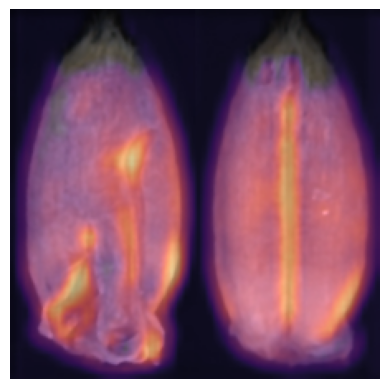

In [322]:
plt.imshow(cam)
plt.axis("off")
plt.show()

Indeed the model predicted class 2: sprouted - and that is exactly what we see hilighted in the image. On the other hand, this model makes a complete mess of images from class 4, as can be seen below, where it miscallsifies it as class 0 , missing entirely the marks of attacks by pests.

In [323]:
test_image_file = df_val[df_val["label"] == 4]["img_path"].iloc[3]

cam = get_grad_cam(
    uncompiled_model,
    test_image_file,
    val_transforms,
    target_layers=target_layers,
)

[01/18/26 22:42:18] INFO     The model predicted class 0                                      ]8;id=390953;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=747148;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:42:18] INFO     The model predicted class 0                                      ]8;id=452414;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=478899;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:42:18] INFO     The model predicted class 0                                      ]8;id=632681;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=573987;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:42:18] INFO     The model predicted class 0                                      ]8;id=132727;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=741440;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:42:18] INFO     The model predicted class 0                                      ]8;id=852965;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=823005;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:42:18] INFO     The model predicted class 0                                      ]8;id=662266;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=690948;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:42:18] INFO     The model predicted class 0                                      ]8;id=173798;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=102068;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:42:18] INFO     The model predicted class 0                                      ]8;id=150369;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=957029;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

[01/18/26 22:42:18] INFO     The model predicted class 0                                      ]8;id=272372;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=666736;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#101\101]8;;\

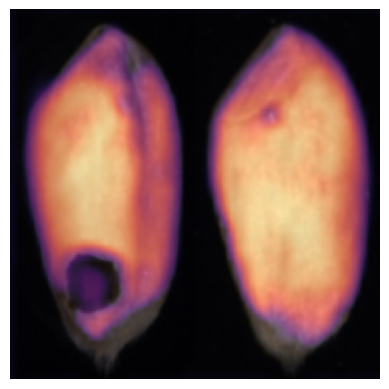

In [324]:
plt.imshow(cam)
plt.axis("off")
plt.show()

Now that we have trained a simple baseline we proceed to train more advanced models. Due to the expense of training large architectures we restrict ourselves to models from the `resnet` family: `resnet10`, `resnet18` and `resnet50`. Training such models takes a long time, so we use a script to do this. The resulting trained models are included in this repository. Below we will simply load the checkpoints and compare the accuracy. To actuall run the training (which takes several hours) see [train.py](train.py)



For all the `resnet` models we start from pretrained models that have already been trained on a large corpus of images, ImageNet. This allows us to take advantage of transfer learning where many of the features that the model would need to learn are already learned. 

To demonstrate the power of transfer learning, consider training `resnet10t` for just 1 (!) epoch.

In [410]:
checkpoint_dir = "checkpoints"
checkpoint_name = "resnet10t_checkpoint_0.pt"
checkpoint = torch.load(os.path.join(checkpoint_dir,checkpoint_name), weights_only=True)


In [ ]:
tr_config = TrainingConfig(**checkpoint["training_config"])
epoch = checkpoint["epoch"]
model_state_dict = checkpoint["model_state_dict"]
opitmizer_state_dict = checkpoint["optimizer_state_dict"]
train_loss = checkpoint["train_loss"]
val_loss = checkpoint["val_loss"]

# Note that we have to reinstatiate the validation dataset,
# since it contains the transforms and those are not the same
# between the baseline model and resnet
new_val_dataset = prepare_dataset(
    "validation_list.json", model_name=tr_config.model_name
)
model_trained = timm.create_model(tr_config.model_name, pretrained=True, num_classes=8)
model_trained = torch.compile(model_trained)
model_trained.load_state_dict(checkpoint["model_state_dict"])

model_trained.eval()
df_trained, val_loss_trained, val_acc_trained = evaluate_model.evaluate_model(
    model_trained,
    new_val_dataset,
    tr_config,
    output_file=f"accuracy_{tr_config.model_name}_trained.csv",
)

[01/18/26 23:20:39] INFO     Creating data loaders                                             ]8;id=531561;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=229349;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/18/26 23:20:39] INFO     Creating data loaders                                             ]8;id=856238;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=381751;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/18/26 23:20:39] INFO     Creating data loaders                                             ]8;id=181403;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=55615;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/18/26 23:20:39] INFO     Creating data loaders                                             ]8;id=346178;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=836931;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/18/26 23:20:39] INFO     Creating data loaders                                             ]8;id=363868;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=707527;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/18/26 23:20:39] INFO     Creating data loaders                                             ]8;id=942929;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=400307;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/18/26 23:20:39] INFO     Creating data loaders                                             ]8;id=110554;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=100066;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/18/26 23:20:39] INFO     Creating data loaders                                             ]8;id=356227;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=324580;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/18/26 23:20:39] INFO     Creating data loaders                                             ]8;id=175294;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=173951;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=588955;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=460651;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=83793;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=802268;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=603854;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=240532;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=91816;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=908640;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=208597;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=940163;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=673865;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=943552;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=756552;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=418150;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=109558;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=97363;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=135971;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=576055;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

[01/18/26 23:23:20] INFO     Done                                                              ]8;id=171460;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=711082;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/18/26 23:23:20] INFO     Done                                                              ]8;id=717798;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=214461;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/18/26 23:23:20] INFO     Done                                                              ]8;id=941032;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=279667;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/18/26 23:23:20] INFO     Done                                                              ]8;id=553056;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=154952;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/18/26 23:23:20] INFO     Done                                                              ]8;id=34044;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=386189;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/18/26 23:23:20] INFO     Done                                                              ]8;id=368029;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=387035;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/18/26 23:23:20] INFO     Done                                                              ]8;id=466624;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=233155;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/18/26 23:23:20] INFO     Done                                                              ]8;id=494986;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=349454;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/18/26 23:23:20] INFO     Done                                                              ]8;id=538210;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=749990;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

                    INFO     Writing labels and predictions to accuracy_resnet10t_trained.csv  ]8;id=232135;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=346179;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#86\86]8;;\

                    INFO     Writing labels and predictions to accuracy_resnet10t_trained.csv  ]8;id=746803;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=980674;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#86\86]8;;\

                    INFO     Writing labels and predictions to accuracy_resnet10t_trained.csv  ]8;id=15071;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=434161;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#86\86]8;;\

                    INFO     Writing labels and predictions to accuracy_resnet10t_trained.csv  ]8;id=547567;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=297076;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#86\86]8;;\

                    INFO     Writing labels and predictions to accuracy_resnet10t_trained.csv  ]8;id=421573;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=980230;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#86\86]8;;\

                    INFO     Writing labels and predictions to accuracy_resnet10t_trained.csv  ]8;id=744672;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=54265;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#86\86]8;;\

                    INFO     Writing labels and predictions to accuracy_resnet10t_trained.csv  ]8;id=103867;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=555050;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#86\86]8;;\

                    INFO     Writing labels and predictions to accuracy_resnet10t_trained.csv  ]8;id=732624;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=598576;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#86\86]8;;\

                    INFO     Writing labels and predictions to accuracy_resnet10t_trained.csv  ]8;id=136824;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=516845;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#86\86]8;;\

Text(0.5, 47.7222222222222, 'Predicted Label')

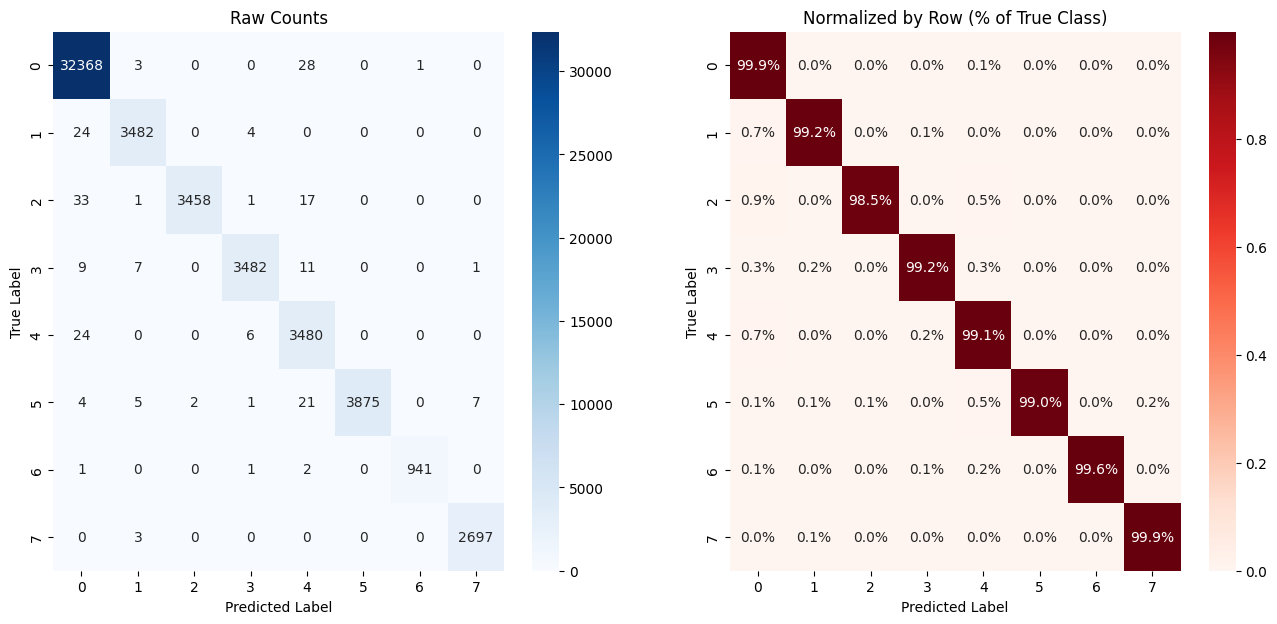

In [ ]:
conf_matrix = confusion_matrix(df_trained["labels"], df_trained["preds"])
# Normalize as percent of the right class
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
# Raw counts
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Raw Counts")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".1%", cmap="Reds", ax=axes[1])
axes[1].set_title("Normalized by Row (% of True Class)")
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")

In [347]:
val_acc_trained

0.9959814814814815

# Comparing different models
We used the following models to build our classifier:

- [`resnet10t`](https://huggingface.co/timm/resnet10t.c3_in1k)
- [`resnet18`](https://huggingface.co/timm/resnet18.a1_in1k)
- [`regnety_008`](https://huggingface.co/timm/regnety_008_tv.tv2_in1k/blob/main/README.md)
- [`mobilenetv3_large`](https://huggingface.co/timm/mobilenetv3_large_100.ra_in1k)

They were selected because they achieve good accuracy on ImageNet while being reasonably lightweight and therefore trainable on a consumer-grade GPU.
The training takes a long time, and thus is not done inside this notebook. See the scripts `train_{model name}.sh`. The final checkpoints after 11 epochs are included in this repo in `./checkpoints`.

In [389]:
from utils import reload_model_for_inference
from evaluate_model import compute_accuracy_measures

In [ ]:
trained_resnet10, tr_config_resnet10 = reload_model_for_inference(
    "resnet10t_checkpoint_10.pt"
)
trained_resnet18, tr_config_resnet18 = reload_model_for_inference(
    "resnet18_checkpoint_10.pt"
)
trained_regnety008, tr_config_regnety008 = reload_model_for_inference(
    "regnety_008_tv.tv2_in1k_checkpoint_10.pt"
)
trained_mobilenet, tr_config_mobilenet = reload_model_for_inference(
    "mobilenetv3_large_100.ra_in1k_checkpoint_10.pt"
)


In [367]:
# Assess all models on the validation set
df_resnet10, val_loss_resnet10, val_acc_resnet10 = evaluate_model.evaluate_model(
    trained_resnet10,
    new_val_dataset,
    tr_config_resnet10,
)

[01/19/26 17:46:16] INFO     Creating data loaders                                             ]8;id=270081;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=191800;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:46:16] INFO     Creating data loaders                                             ]8;id=287516;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=590200;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:46:16] INFO     Creating data loaders                                             ]8;id=330219;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=758647;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:46:16] INFO     Creating data loaders                                             ]8;id=680089;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=901129;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:46:16] INFO     Creating data loaders                                             ]8;id=58349;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=402272;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:46:16] INFO     Creating data loaders                                             ]8;id=837803;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=841520;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:46:16] INFO     Creating data loaders                                             ]8;id=660381;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=711503;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:46:16] INFO     Creating data loaders                                             ]8;id=719994;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=14398;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:46:16] INFO     Creating data loaders                                             ]8;id=92921;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=451674;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=19010;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=694272;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=663343;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=319527;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=311800;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=683804;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=188172;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=834803;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=897808;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=199873;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=952395;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=320527;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=165259;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=261281;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=310212;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=749762;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=976315;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=519255;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

[01/19/26 17:49:30] INFO     Done                                                              ]8;id=801510;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=789719;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:49:30] INFO     Done                                                              ]8;id=3818;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=833170;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:49:30] INFO     Done                                                              ]8;id=397808;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=954927;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:49:30] INFO     Done                                                              ]8;id=577112;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=232955;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:49:30] INFO     Done                                                              ]8;id=837641;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=577217;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:49:30] INFO     Done                                                              ]8;id=329505;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=327334;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:49:30] INFO     Done                                                              ]8;id=596861;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=996999;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:49:30] INFO     Done                                                              ]8;id=500790;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=291097;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:49:30] INFO     Done                                                              ]8;id=392166;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=519908;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

In [369]:
df_resnet18, val_loss_resnet18, val_acc_resnet18 = evaluate_model.evaluate_model(
    trained_resnet18,
    new_val_dataset,
    tr_config_resnet18,
)


[01/19/26 17:50:54] INFO     Creating data loaders                                             ]8;id=361114;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=634318;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:50:54] INFO     Creating data loaders                                             ]8;id=734300;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=849939;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:50:54] INFO     Creating data loaders                                             ]8;id=708184;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=531189;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:50:54] INFO     Creating data loaders                                             ]8;id=522115;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=408483;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:50:54] INFO     Creating data loaders                                             ]8;id=796220;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=414796;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:50:54] INFO     Creating data loaders                                             ]8;id=195775;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=591269;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:50:54] INFO     Creating data loaders                                             ]8;id=878210;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=148089;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:50:54] INFO     Creating data loaders                                             ]8;id=652084;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=836428;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:50:54] INFO     Creating data loaders                                             ]8;id=21792;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=856291;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=755657;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=20164;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=298605;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=96359;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=709145;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=689580;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=799806;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=203589;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=730247;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=480492;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=163151;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=17355;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=153205;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=694689;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=869412;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=143679;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=478337;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=206985;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

[01/19/26 17:55:26] INFO     Done                                                              ]8;id=207511;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=648399;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:55:26] INFO     Done                                                              ]8;id=49751;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=568691;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:55:26] INFO     Done                                                              ]8;id=370290;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=978451;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:55:26] INFO     Done                                                              ]8;id=70994;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=442893;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:55:26] INFO     Done                                                              ]8;id=615400;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=871118;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:55:26] INFO     Done                                                              ]8;id=979627;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=904554;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:55:26] INFO     Done                                                              ]8;id=253550;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=715198;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:55:26] INFO     Done                                                              ]8;id=31765;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=886489;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 17:55:26] INFO     Done                                                              ]8;id=634606;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=709324;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

In [370]:
df_regnety008, val_loss_regnety008, val_acc_regnety008 = evaluate_model.evaluate_model(
    trained_regnety008,
    new_val_dataset,
    tr_config_regnety008,
)

[01/19/26 17:55:40] INFO     Creating data loaders                                             ]8;id=710660;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=66417;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:55:40] INFO     Creating data loaders                                             ]8;id=219487;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=420068;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:55:40] INFO     Creating data loaders                                             ]8;id=449529;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=776331;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:55:40] INFO     Creating data loaders                                             ]8;id=747511;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=922620;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:55:40] INFO     Creating data loaders                                             ]8;id=607797;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=223612;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:55:40] INFO     Creating data loaders                                             ]8;id=362984;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=704668;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:55:40] INFO     Creating data loaders                                             ]8;id=307384;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=482889;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:55:40] INFO     Creating data loaders                                             ]8;id=986176;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=220436;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 17:55:40] INFO     Creating data loaders                                             ]8;id=761909;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=856197;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=754574;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=663855;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=6800;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=807079;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=398423;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=342305;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=470992;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=614917;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=82267;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=933580;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=848162;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=894735;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=207552;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=303357;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=797584;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=867089;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=817955;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=260410;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

[01/19/26 18:01:23] INFO     Done                                                              ]8;id=996861;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=476415;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 18:01:23] INFO     Done                                                              ]8;id=188926;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=78659;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 18:01:23] INFO     Done                                                              ]8;id=324320;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=716681;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 18:01:23] INFO     Done                                                              ]8;id=214015;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=263689;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 18:01:23] INFO     Done                                                              ]8;id=202683;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=844152;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 18:01:23] INFO     Done                                                              ]8;id=578952;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=337857;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 18:01:23] INFO     Done                                                              ]8;id=815036;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=252531;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 18:01:23] INFO     Done                                                              ]8;id=120444;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=754795;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 18:01:23] INFO     Done                                                              ]8;id=141391;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=136783;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

In [373]:
df_mobilenet, val_loss_mobilenet, val_acc_mobilenet = evaluate_model.evaluate_model(
    trained_mobilenet,
    new_val_dataset,
    tr_config_mobilenet,
)

[01/19/26 18:58:38] INFO     Creating data loaders                                             ]8;id=889190;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=307903;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 18:58:38] INFO     Creating data loaders                                             ]8;id=492342;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=25627;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 18:58:38] INFO     Creating data loaders                                             ]8;id=75348;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=416016;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 18:58:38] INFO     Creating data loaders                                             ]8;id=838068;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=22433;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 18:58:38] INFO     Creating data loaders                                             ]8;id=690616;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=86457;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 18:58:38] INFO     Creating data loaders                                             ]8;id=241192;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=304536;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 18:58:38] INFO     Creating data loaders                                             ]8;id=766656;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=877166;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 18:58:38] INFO     Creating data loaders                                             ]8;id=984281;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=773742;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

[01/19/26 18:58:38] INFO     Creating data loaders                                             ]8;id=391278;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=396975;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#37\37]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=519343;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=649416;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=498634;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=11746;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=266725;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=710992;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=184115;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=160851;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=212876;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=581004;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=718831;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=357552;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=226035;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=869934;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=943719;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=680854;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=603185;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=955108;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#53\53]8;;\

[01/19/26 19:00:21] INFO     Done                                                              ]8;id=356689;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=387556;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 19:00:21] INFO     Done                                                              ]8;id=334501;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=215453;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 19:00:21] INFO     Done                                                              ]8;id=379343;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=159739;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 19:00:21] INFO     Done                                                              ]8;id=732578;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=191233;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 19:00:21] INFO     Done                                                              ]8;id=866200;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=536246;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 19:00:21] INFO     Done                                                              ]8;id=827378;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=302853;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 19:00:21] INFO     Done                                                              ]8;id=207495;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=581230;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 19:00:21] INFO     Done                                                              ]8;id=124564;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=887809;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

[01/19/26 19:00:21] INFO     Done                                                              ]8;id=568287;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=456316;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#80\80]8;;\

In [402]:
def get_number_of_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    return total

In [403]:
names = ["resnet10", "resnet18", "regnety008", "mobilenet100"]
acc_results = [df_resnet10, df_resnet18, df_regnety008, df_mobilenet]
num_params = [
    get_number_of_parameters(trained_resnet10),
    get_number_of_parameters(trained_resnet18),
    get_number_of_parameters(trained_regnety008),
    get_number_of_parameters(trained_mobilenet),
]


In [406]:
nums_data = dict(zip(names,num_params))

In [407]:
accs_data = dict(zip(names, acc_results))

In [408]:
final_val_scores = []
for k, v in accs_data.items():
    tmp = compute_accuracy_measures(v, average="micro")
    final_val_scores.append([k, *tmp,nums_data[k]])
final_val_scores = pd.DataFrame(
    final_val_scores, columns=["model", "precision", "recall", "f1_score","num_params"]
)

precision: 0.9989074074074074 - recall: 0.9989074074074074 - f1_score: 0.9989074074074074
precision: 0.9986666666666667 - recall: 0.9986666666666667 - f1_score: 0.9986666666666667
precision: 0.9987222222222222 - recall: 0.9987222222222222 - f1_score: 0.9987222222222222
precision: 0.9982037037037037 - recall: 0.9982037037037037 - f1_score: 0.9982037037037037


In [409]:
final_val_scores.sort_values("f1_score", ascending=False)

,model,precision,recall,f1_score,num_params
0,resnet10,0.998907,0.998907,0.998907,4926592
2,regnety008,0.998722,0.998722,0.998722,5653792
1,resnet18,0.998667,0.998667,0.998667,11180616
3,mobilenet100,0.998204,0.998204,0.998204,4212280


Looking at the results, there is basically no meaningful difference between the models. It might be interesting to examine the confusion matrices to see if a particular model has an advantage there.

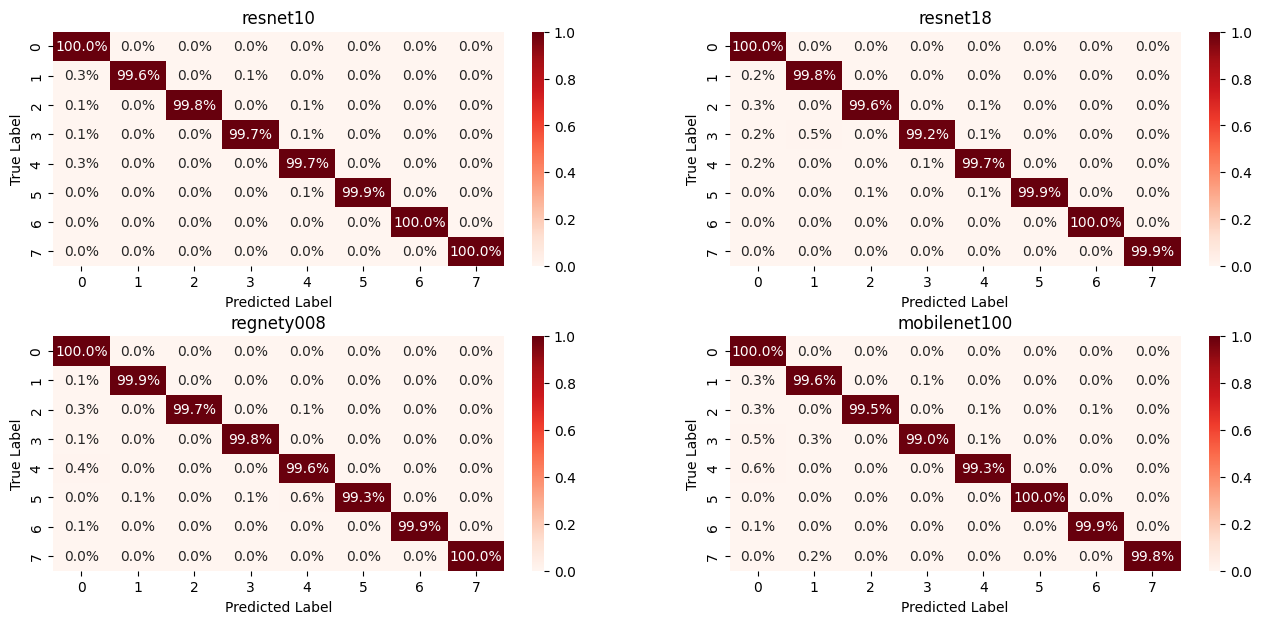

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 7))
axes = axes.flatten()
for i, (k, v) in enumerate(accs_data.items()):
    conf_matrix = confusion_matrix(v["labels"], v["preds"])
    # Normalize as percent of the right class
    conf_matrix_normalized = (
        conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
    )

    # Raw counts
    sns.heatmap(
        conf_matrix_normalized,
        annot=True,
        fmt=".1%",
        cmap="Reds",
        ax=axes[i],
        vmin=0,
        vmax=1,
    )
    axes[i].set_title("Normalized by Row (% of True Class)")
    axes[i].set_ylabel("True Label")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_title(k)

plt.subplots_adjust(hspace=0.3)

There are very few differences here as well and the numbers could easily change on the level we see here if we were to pick a different validation set. Thus we select `resnet10` since it achieves very good results while having the 2nd lowest number of parameters.

# Evaluate final model on test set
We now train our model on the whole training set. Given the already excellent performance of the model above, we don't start from scratch but continue from the trained model. See [script](train_final_resnet.sh)

In [416]:
final_model,final_config = reload_model_for_inference("./checkpoints/resnet10t_final.pt")

In [417]:
test_dataset = prepare_dataset(
    "test_list.json", model_name=tr_config_resnet10.model_name
)

In [418]:
df_final, val_loss_final, val_acc_final= evaluate_model.evaluate_model(
    final_model,
    test_dataset,
    final_config,
)

[01/19/26 19:50:01] INFO     Creating data loaders                                             ]8;id=360365;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=536201;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#38\38]8;;\

[01/19/26 19:50:01] INFO     Creating data loaders                                             ]8;id=928890;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=319043;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#38\38]8;;\

[01/19/26 19:50:01] INFO     Creating data loaders                                             ]8;id=243351;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=366625;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#38\38]8;;\

[01/19/26 19:50:01] INFO     Creating data loaders                                             ]8;id=74091;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=826927;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#38\38]8;;\

[01/19/26 19:50:01] INFO     Creating data loaders                                             ]8;id=957013;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=178786;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#38\38]8;;\

[01/19/26 19:50:01] INFO     Creating data loaders                                             ]8;id=152874;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=215073;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#38\38]8;;\

[01/19/26 19:50:01] INFO     Creating data loaders                                             ]8;id=795952;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=220501;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#38\38]8;;\

[01/19/26 19:50:01] INFO     Creating data loaders                                             ]8;id=611407;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=154254;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#38\38]8;;\

[01/19/26 19:50:01] INFO     Creating data loaders                                             ]8;id=521022;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=490552;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#38\38]8;;\

[01/19/26 19:50:01] INFO     Creating data loaders                                             ]8;id=344982;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=842798;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#38\38]8;;\

[01/19/26 19:50:01] INFO     Creating data loaders                                             ]8;id=416770;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=867088;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#38\38]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=984330;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=853091;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#54\54]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=263496;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=881170;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#54\54]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=513831;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=601654;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#54\54]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=468915;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=488298;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#54\54]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=626707;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=239368;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#54\54]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=210942;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=621473;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#54\54]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=290176;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=528482;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#54\54]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=203885;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=531161;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#54\54]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=596000;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=980833;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#54\54]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=149529;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=707760;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#54\54]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=453186;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=522301;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#54\54]8;;\

[01/19/26 19:50:28] INFO     Done                                                              ]8;id=162251;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=827299;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#81\81]8;;\

[01/19/26 19:50:28] INFO     Done                                                              ]8;id=380769;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=405415;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#81\81]8;;\

[01/19/26 19:50:28] INFO     Done                                                              ]8;id=76772;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=335677;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#81\81]8;;\

[01/19/26 19:50:28] INFO     Done                                                              ]8;id=728408;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=377009;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#81\81]8;;\

[01/19/26 19:50:28] INFO     Done                                                              ]8;id=128673;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=526499;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#81\81]8;;\

[01/19/26 19:50:28] INFO     Done                                                              ]8;id=180377;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=871540;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#81\81]8;;\

[01/19/26 19:50:28] INFO     Done                                                              ]8;id=218023;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=940204;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#81\81]8;;\

[01/19/26 19:50:28] INFO     Done                                                              ]8;id=792061;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=944914;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#81\81]8;;\

[01/19/26 19:50:28] INFO     Done                                                              ]8;id=781184;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=14449;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#81\81]8;;\

[01/19/26 19:50:28] INFO     Done                                                              ]8;id=495768;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=269865;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#81\81]8;;\

[01/19/26 19:50:28] INFO     Done                                                              ]8;id=231517;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=828905;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#81\81]8;;\

In [419]:
compute_accuracy_measures(df_final, average="micro")

precision: 0.99905 - recall: 0.99905 - f1_score: 0.99905


[0.99905, 0.99905, 0.99905]

We see that our final model has excellent performance on the held out set. Let's examine the confusion matrix

Text(0.5, 47.7222222222222, 'Predicted Label')

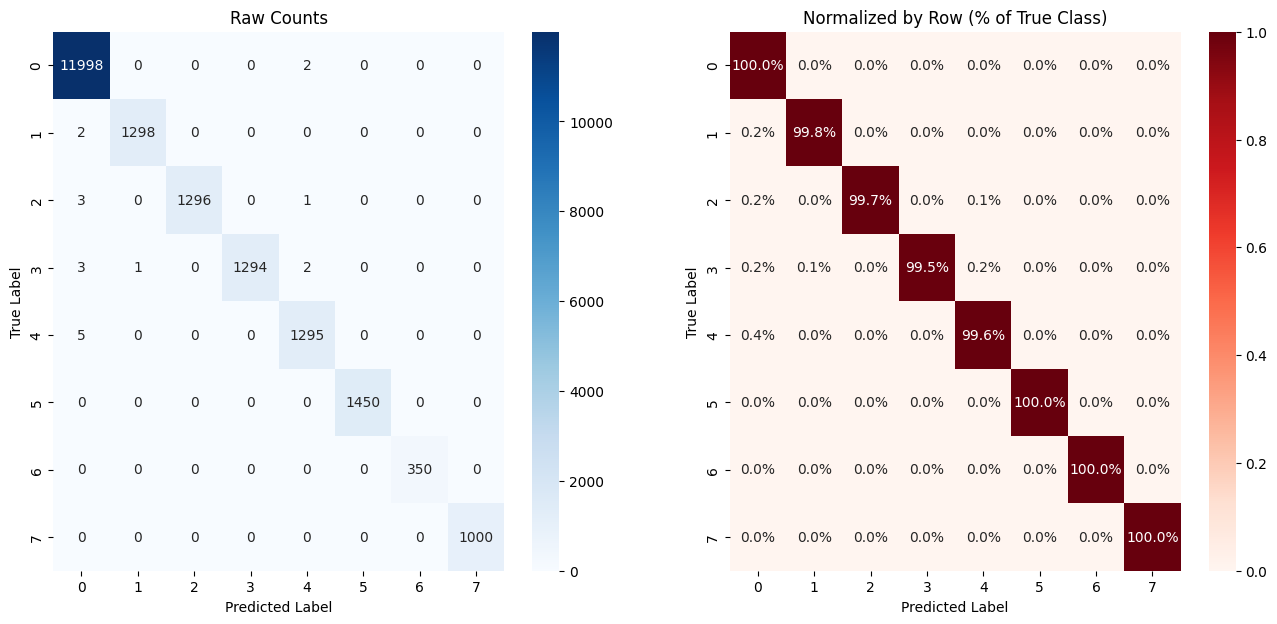

In [420]:
conf_matrix = confusion_matrix(df_final["labels"], df_final["preds"])
# Normalize as percent of the right class
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
# Raw counts
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Raw Counts")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".1%", cmap="Reds", ax=axes[1])
axes[1].set_title("Normalized by Row (% of True Class)")
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")

Lastly we save our model to ONNX format so it can be used easily for inference.

In [429]:
from utils import save_model_to_onnx

In [430]:
save_model_to_onnx(final_model,'resnet10_final.onnx',device=device)

[torch.onnx] Obtain model graph for `OptimizedModule([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `OptimizedModule([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


/usr/lib/python3.12/copyreg.py:99: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  return cls.__new__(cls, *args)


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 28 of general pattern rewrite rules.
